In [1]:
import os
import cv2
import json
import pandas as pd
import matplotlib.patches as patches
import torch as T

from matplotlib import pyplot as plt

from motion_capture.data.datasets import scale_points, center_bbox
from torch.utils import data
from torchvision.io import read_image
from torchvision.transforms.functional import resize, crop

from torch.nn.functional import one_hot

%matplotlib inline

# WIDER Face

In [2]:
from motion_capture.data.datasets import WIDERFaceDataset
from motion_capture.data.preprocessing import ImagePertubators

number_of_faces = 10
image_shape = (448, 224)
wider_face_dataset = WIDERFaceDataset(
    output_image_shape_WH=image_shape, 
    max_number_of_faces=number_of_faces,
    train_path="//192.168.2.206/data/datasets/WIDER-Face/train",
    val_path="//192.168.2.206/data/datasets/WIDER-Face/val",
    image_pertubator=ImagePertubators.BASIC(),
    center_bbox=True)
len(wider_face_dataset)

12479

In [3]:
# time the access time of the dataset
import time
start = time.time()
for i in range(32):
    wider_face_dataset[i]
print(time.time() - start)

time - load image     : 1.0062508000410162
time - proc bbox      : 0.00045630004024133086
time - pad and resize : 0.00178240000968799
time - load image     : 0.029536800051573664
time - proc bbox      : 0.00032599997939541936
time - pad and resize : 0.004212600004393607
time - load image     : 0.06142829998861998
time - proc bbox      : 0.0022982999798841774
time - pad and resize : 0.002223099989350885
time - load image     : 0.041817500023171306
time - proc bbox      : 0.0011452999897301197
time - pad and resize : 0.001492900017183274
time - load image     : 0.019011500000488013
time - proc bbox      : 0.00044709997018799186
time - pad and resize : 0.0016675000078976154
time - load image     : 0.03363249998074025
time - proc bbox      : 0.0013651999761350453
time - pad and resize : 0.001394100021570921
time - load image     : 0.05035670002689585
time - proc bbox      : 0.0009996999870054424
time - pad and resize : 0.0030929999775253236
time - load image     : 0.16868470003828406
time 

In [ ]:
# face_counts = pd.Series([anot_dp["numberOfFaces"] for anot_dp in wider_face_dataset.annotation_datapoints]).value_counts()
# face_counts[:20].plot.bar()
# plt.title("number datapoints over number of faces")
# plt.show()

number of faces 1


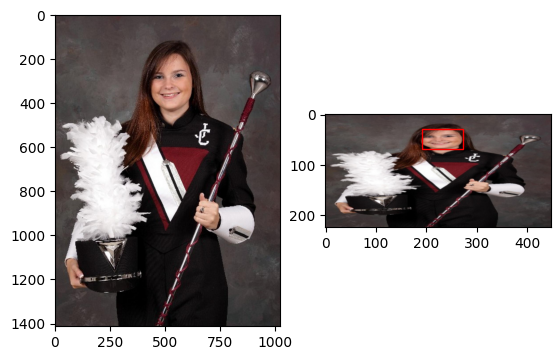

In [ ]:
test_i = 11

original_image = cv2.cvtColor(cv2.imread(wider_face_dataset.annotation_datapoints[test_i]["imagePath"]), cv2.COLOR_BGR2RGB)
_, ax = plt.subplots(1, 2)

# plot original image
ax[0].imshow(original_image)

# plot image with bounding boxes
print(f"number of faces {wider_face_dataset.annotation_datapoints[test_i]['numberOfFaces']}")
test_image = wider_face_dataset[test_i]["image"].permute(1, 2, 0).round().byte().numpy()
faces = wider_face_dataset[test_i]["faceBbox"]
ax[1].imshow(test_image)

for i in range(faces.shape[0]):
    x, y = faces[i][0]
    w, h = faces[i][1]
    ax[1].add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

# plt.show()

---

# WFLW

In [3]:
from motion_capture.data.datasets import WFLWDataset
from motion_capture.data.preprocessing import ImagePertubators

wflw_dataset = WFLWDataset(
    output_full_image_shape_WH=(224, 224),
    output_face_image_shape_WH=(112, 112),
    image_path="//192.168.2.206/data/datasets/WFLW/images",
    annotation_path="//192.168.2.206/data/datasets/WFLW/annotations",
    max_number_of_faces=10,
    image_pertubator=ImagePertubators.BASIC())
len(wflw_dataset)

6551

in collate: (224, 224)


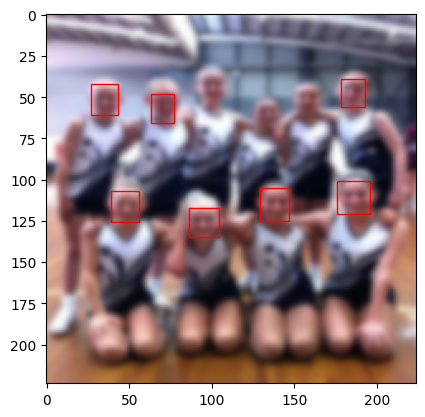

: 

In [16]:
# test collate function
collate_test = wflw_dataset.collate_fn_bbox([wflw_dataset[3]])

test_image = (collate_test[0].squeeze() * 255).to(T.uint8).permute(1, 2, 0).numpy()
test_bboxes = collate_test[1].squeeze() # * T.tensor([wflw_dataset.output_full_image_shape] * 2).flatten()

plt.imshow(test_image)

for bbox in test_bboxes:
    x, y = bbox[:2] * 224
    w, h = bbox[2:] * 224
    plt.gca().add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))


KeyError: 'fullImage'

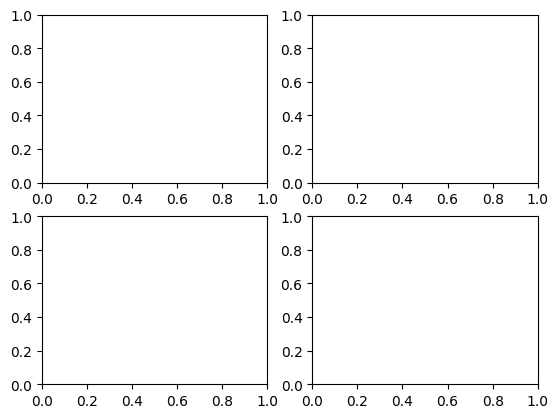

In [5]:
test_i = 1

num_faces = sum(wflw_dataset[test_i]["faceValidity"]).item()

_, ax = plt.subplots(num_faces, 2)

test_full_image = wflw_dataset[test_i]["fullImage"].to(dtype=T.uint8).permute(1, 2, 0).round().byte().numpy()

print(f"number of faces {num_faces}")
for i in range(num_faces):

    test_face_image = wflw_dataset[test_i]["faceImages"][i].to(dtype=T.uint8).permute(1, 2, 0).round().byte().numpy()
    
    # plot full images
    ax[i, 0].imshow(test_full_image)
    
    # plot bounding box
    x, y = wflw_dataset[test_i]["faceBboxes"][i][0]
    w, h = wflw_dataset[test_i]["faceBboxes"][i][1]
    ax[i, 0].add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))
    
    # plot face image
    ax[i, 1].imshow(test_face_image)

# x, y = wflw_dataset[test_i]["faceBbox"][0]
# w, h = wflw_dataset[test_i]["faceBbox"][1]
# ax[0].add_patch(
#     patches.Rectangle(
#         (x-w, y-h), 
#         w*2, h*2, 
#         linewidth=1, 
#         edgecolor="red", 
#         facecolor="none"))

# for dp in wflw_dataset[test_i]["globalKeypoints"]:
#     ax[0].plot(dp[0], dp[1], "ro", markersize=2)

# # plot face image and keypoints
# ax[1].imshow(test_face_image)

# for dp in wflw_dataset[test_i]["localKeypoints"]:
#     ax[1].plot(dp[0], dp[1], "ro", markersize=2)


plt.show()

# COFW

In [5]:
from motion_capture.data.datasets import COFWColorDataset

cofw_color_dataset = COFWColorDataset(
    output_full_image_shape_WH=(448, 224),
    output_face_image_shape_WH=(224, 112),
    data_path="//192.168.2.206/data/datasets/COFW/")
len(cofw_color_dataset)

1852

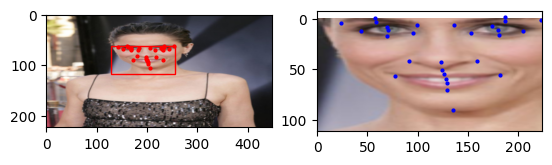

In [10]:
test_i = 3

test_full_image = cofw_color_dataset[test_i]["fullImage"].permute(1, 2, 0).round().byte().numpy()
test_face_image = cofw_color_dataset[test_i]["faceImage"].permute(1, 2, 0).round().byte().numpy()

_, ax = plt.subplots(1, 2)

# plot full image, bounding box and keypoints
ax[0].imshow(test_full_image)

x, y = cofw_color_dataset[test_i]["faceBbox"][0]
w, h = cofw_color_dataset[test_i]["faceBbox"][1]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

for dp in cofw_color_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

# plot face image and keypoints
ax[1].imshow(test_face_image)

kpts = cofw_color_dataset[test_i]["localKeypoints"]
for i in range(kpts.shape[0]):
    if cofw_color_dataset[test_i]["keypointOcclusion"][i] == 1:
        ax[1].plot(kpts[i][0], kpts[i][1], "bo", markersize=2)
    else:
        ax[1].plot(kpts[i][0], kpts[i][1], "ro", markersize=2)

plt.show()

# MPII

In [6]:
from motion_capture.data.datasets import MPIIDataset

mpii_dataset = MPIIDataset(
    output_full_image_shape_WH=(448, 224),
    output_person_image_shape_WH=(224, 112),
    annotation_path="//192.168.2.206/data/datasets/MPII/annotations",
    image_folder_path="//192.168.2.206/data/datasets/MPII/images"
)
len(mpii_dataset)

29116

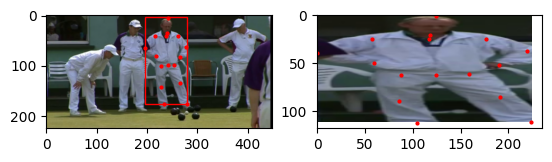

In [7]:
test_i = 110


_, ax = plt.subplots(1, 2)

# plot full image, keypoints, center and bounding box
ax[0].imshow(mpii_dataset[test_i]["fullImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

x, y = mpii_dataset[test_i]["personBbox"][0]
w, h = mpii_dataset[test_i]["personBbox"][1]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

# plot person image and keypoints
ax[1].imshow(mpii_dataset[test_i]["personImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["localKeypoints"]:
    ax[1].plot(dp[0], dp[1], "ro", markersize=2)

plt.show()

# COCO Panoptics

In [2]:
from motion_capture.data.datasets import COCO2017PanopticsDataset
from motion_capture.data.preprocessing import ImagePertubators


coco_panoptic_dataset = COCO2017PanopticsDataset(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    panoptics_path = "//192.168.2.206/data/datasets/COCO2017/panoptic_annotations_trainval2017/annotations",
    output_image_shape_WH=(448, 448),
    instance_images_output_shape_WH=(224, 224),
    load_segmentation_masks=False,
    image_pertubator=ImagePertubators.BASIC()
)
len(coco_panoptic_dataset)

!! WARNING: COCO2017PanopticsDataset segmentation masks contain images not referenced in the image folder, checking will take significantly longer !!


123287

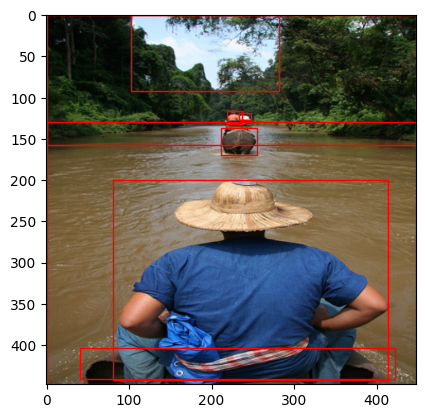

: 

In [11]:
test_i = 1009

image = coco_panoptic_dataset[test_i]["image"].to(dtype=T.uint8)

_, ax = plt.subplots(1)

# plot full image and bounding box
ax.imshow(image.permute(1,2,0).byte().numpy())
for bbox in coco_panoptic_dataset[test_i]["bboxes"]:
    x, y = bbox[0]
    w, h = bbox[1]
    ax.add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

# # plot segmentation mask
# ax[0, 1].imshow(coco_panoptic_dataset[test_i]["segmentationMask"].permute(1,2,0).byte().numpy())

# # plot instance images
# instance_i = 2
# ax[1, 0].imshow(coco_panoptic_dataset[test_i]["instanceImages"][instance_i].permute(1,2,0).byte().numpy())
# ax[1, 1].imshow(coco_panoptic_dataset[test_i]["instanceMaskImages"][instance_i].permute(1,2,0).byte().numpy())

plt.show()

# COCO Captions

In [8]:
class COCO2017CaptionsDataset(data.Dataset):
    
    def __init__(
        self,
        image_folder_path: str,
        annotation_folder_path: str):
        
        super().__init__()
        
        self.image_folder_path = image_folder_path
        self.annotation_path = annotation_folder_path
        
        with open(os.path.join(annotation_folder_path, "captions_train2017.json"), "r") as f:
            self.train_datapoints = json.load(f)
            
        with open(os.path.join(annotation_folder_path, "captions_val2017.json"), "r") as f:
            self.val_datapoints = json.load(f)
            
    def __len__(self):
        return len(self.all_datapoints)
    
    def __getitem__(self, idx):
        return self.all_datapoints[idx]

# COCO Person Keypoints

In [13]:
from motion_capture.data.datasets import COCO2017PersonKeypointsDataset

coco_dataset = COCO2017PersonKeypointsDataset(
    image_folder_path="//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path="//192.168.2.206/data/datasets/COCO2017/annotations",
    output_full_image_shape_WH=(448, 224),
    output_person_image_shape_WH=(224, 112),
    load_val_only=False
)
len(coco_dataset)

38840

1


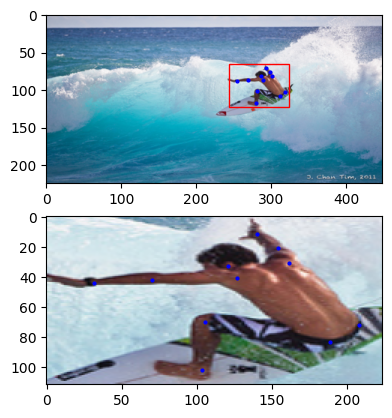

In [7]:
test_i = 20000

full_image = coco_dataset[test_i]["fullImage"].permute(1, 2, 0).round().byte().numpy()

num_persons = coco_dataset[test_i]["personImages"].shape[0]

print(num_persons)

# create plot scale it to number of persons
fig, ax = plt.subplots(num_persons + 1)
# fig.set_size_inches(10, 10 * (num_persons + 1))


ax[0].imshow(full_image)

for i in range(num_persons):
    
    # keypoints, bounding box and segmentation in full image
    kpts = coco_dataset[test_i]["globalKeypoints"][i]
    vis = coco_dataset[test_i]["keypointVisibility"][i]
    val = coco_dataset[test_i]["keypointValidity"][i]
    
    for j in range(kpts.shape[0]):
        if vis[j]:
            ax[0].plot(kpts[j][0], kpts[j][1], "bo", markersize=2)
        elif val[j]:
            ax[0].plot(kpts[j][0], kpts[j][1], "ro", markersize=2)
    
    x, y = coco_dataset[test_i]["personBboxes"][i][0]
    w, h = coco_dataset[test_i]["personBboxes"][i][1]
    ax[0].add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

    # plot individual person image and keypoints
    person_image = coco_dataset[test_i]["personImages"][i].permute(1, 2, 0).round().byte().numpy()
    ax[i+1].imshow(person_image)
    
    kpts = coco_dataset[test_i]["localKeypoints"][i]
    vis = coco_dataset[test_i]["keypointVisibility"][i]
    val = coco_dataset[test_i]["keypointValidity"][i]
    for j in range(kpts.shape[0]):
        if vis[j]:
            ax[i+1].plot(kpts[j][0], kpts[j][1], "bo", markersize=2)
        elif val[j]:
            ax[i+1].plot(kpts[j][0], kpts[j][1], "ro", markersize=2)

plt.show()


# COCO Whole Body

In [15]:
from motion_capture.data.datasets import COCO2017WholeBodyDataset

coco_wholebody_dataset = COCO2017WholeBodyDataset(
    annotations_folder_path="//192.168.2.206/data/datasets/COCO2017/annotations",
    image_folder_path="//192.168.2.206/data/datasets/COCO2017/images",
    full_image_shape_WH=(448, 448),
    person_image_shape_WH=(224, 224),
    bodypart_image_shape_WH=(112, 112),
    load_val_only=False)
len(coco_wholebody_dataset)

70563

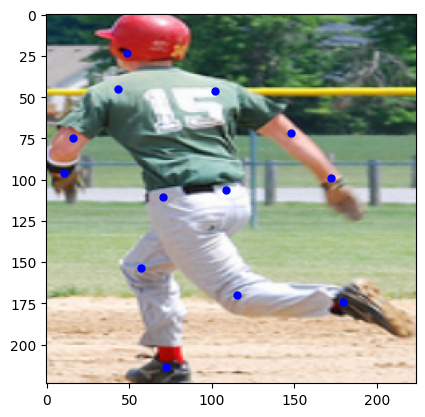

In [27]:
test_i = 10108


_, ax = plt.subplots(1)

# plot person image
ax.imshow(coco_wholebody_dataset[test_i]["personImages"].permute(1, 2, 0).byte().numpy())

# plot keypoints
kpts = coco_wholebody_dataset[test_i]["keypoints"]
vis = coco_wholebody_dataset[test_i]["keypointsVisibility"]
val = coco_wholebody_dataset[test_i]["keyponitsValidity"]
for j in range(kpts.shape[0]):
    if vis[j]:
        ax.plot(kpts[j][0], kpts[j][1], "bo", markersize=5)
    elif val[j]:
        ax.plot(kpts[j][0], kpts[j][1], "ro", markersize=5)

# plot bounding boxes
bboxes = [
    coco_wholebody_dataset[test_i]["faceBbox"],
    coco_wholebody_dataset[test_i]["leftHandBbox"],
    coco_wholebody_dataset[test_i]["rightHandBbox"]
]

for bbox in bboxes:
    x, y = bbox[0]
    w, h = bbox[1]
    ax.add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))



plt.show()

# HAKE Large

# hico_det

In [ ]:
# hd = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno.mat")
# hd_bb = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno_bbox.mat")

# """

# len(hd_bb["bbox_train"][0][i][1][0]) = 1

# len(hd_bb["bbox_train"][0][i][0]) = 1
# (name)


# """

In [ ]:
# hd_bb.keys()

In [ ]:
# print(len(hd["list_train"]), len(hd["list_test"]))

# hd_bb["bbox_train"][0][0][0]
# hd_bb["bbox_train"][0][0][1]

# for i in range(len(hd_bb["bbox_train"][0])):
#     image_name = hd_bb["bbox_train"][0][i][0][0]

#     width, height, depth = hd_bb["bbox_train"][0][i][1][0][0]
#     width, height, depth = width[0][0], height[0][0], depth[0][0]


# sum([len(hd_bb["bbox_train"][0][i][2][0]) for i in range(len(hd_bb["bbox_train"][0]))])

# [b[1] for b in hd_bb["bbox_train"][0][0][2][0]]




# RHDv2

In [ ]:
# arr = pickle.load(open("./../_data/_usefull/_images/RHD_published_v2/training/anno_training.pickle", "br"))

"""

arr[i]["xyz"] = xyz keypoints
arr[i]["uv_vis] = uv + visibility
arr[i]["K"] = camera
(i == image)


"""
None

# HAKE

In [ ]:
# hake_large_annotation = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hake_large_annotation.json", "r"))
# hico_det_training_set_instance_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-det-training-set-instance-level.json", "r"))
# hico_training_set_image_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-training-set-image-level.json", "r"))

"""

hico training set image level

{'arm_list': [0, 0, 0, 0, 1], 
'foot_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'hand_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'head_list': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
'hip_list': [1, 0, 0, 0, 0], 
'hoi_id': [153, 154, 155, 156], 
'leg_list': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
'parts_list': [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]}


hico det training set instance level

{'dataset': 'hico-det', 
'labels': [
    {
        'action_labels': 
            [{'human_part': 6, 'partstate': 0}, 
            {'human_part': 9, 'partstate': 0}, 
            {'human_part': 4, 'partstate': 0}, 
            {'human_part': 0, 'partstate': 0}, 
            {'human_part': 3, 'partstate': 0}], 
        'height': 480, 
        'hoi_id': 153, 
        'human_bbox': [208, 33, 427, 300], 
        'object_bbox': [59, 98, 572, 405], 
        'width': 640
    }, 
    {
        'action_labels': 
            [{'human_part': 4, 'partstate': 0}, 
            {'human_part': 1, 'partstate': 6}, 
            {'human_part': 2, 'partstate': 6}], 
        'height': 480, 
        'hoi_id': 156, 
        'human_bbox': [209, 26, 444, 317], 
        'object_bbox': [59, 99, 579, 395], 
        'width': 640
    },
        ...], 
'path_prefix': 'hico_20160224_det/images/train2015'}



hake large annotation

{'dataset': 'hico-det', 
'labels': [
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 153, 'human_bbox': [208, 33, 427, 300], 'object_bbox': [59, 98, 572, 405], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 4, 'partstate': 0}, {'human_part': 1, 'partstate': 6}, {'human_part': 2, 'partstate': 6}], 'height': 480, 'hoi_id': 156, 'human_bbox': [209, 26, 444, 317], 'object_bbox': [59, 99, 579, 395], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 154, 'human_bbox': [213, 20, 438, 357], 'object_bbox': [77, 115, 583, 396], 'width': 640}, {'action_labels': [{'human_part': 4, 'partstate': 0}], 'height': 480, 'hoi_id': 155, 'human_bbox': [206, 33, 427, 306], 'object_bbox': [61, 100, 571, 401], 'width': 640}], 
    ...
    
'path_prefix': 'hico_20160224_det/images/train2015'}


"""
None

# FreiHAND

In [ ]:
"""
training_K = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_K.json", "r"))
training_mano = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_mano.json", "r"))
training_scale = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_scale.json", "r"))
training_verts = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_verts.json", "r"))
training_xyz = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_xyz.json", "r"))

# length is the same for all = 32560 = number of greenscreened images

K = intrinsic camera matrix
mano = mano annotations ?
verts = 3d vertecies
xyz = 3d shape
"""

# Kinect

In [ ]:
# info = json.load(open("./../_data/_usefull/KinectDatasets/data/training/info.json", "r"))
# calib = json.load(open("./../_data/_usefull/KinectDatasets/data/training/calib.json", "r"))
# anno = json.load(open("./../_data/_usefull/KinectDatasets/data/training/anno.json", "r"))
# pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/training/pred_sdk.json", "r"))

# captury_info = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/info.json", "r"))
# captury_calib = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/calib.json", "r"))
# captury_anno = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/anno.json", "r"))
# captury_pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk.json", "r"))
# captury_pred_sdk_cap = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk_cap.json", "r"))

"""
1920x1080

anno[0][0] = 18 kpts + vis

pred_sdk[0][i] = 25 kpts + vis (is a prediction)
(i == 4 for all)


captury_pred_sdk[0][i] = 25 kpts + vis
(i == 1 for all)

captury_pred_sdk_cap[0][i] = 25 kpts + vis
(i == 2 for all)


"""
None